# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Four Factor Model

## Contents
[1. Feature Creation](#1.-Feature-Creation)<br>
[2. Train-Test-Split](#2.-Train-Test-Split)<br>
[3. Model Creation](#3.-Model-Creation)<br>

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 9999)
pd.set_option('display.max_rows', 200)

In [3]:
nba_data = pd.read_csv('../data/nba_data.csv')

### 1. Feature Creation

The Four Factor Model (https://www.basketball-reference.com/about/factors.html) is made up shooting, turnovers, rebounding and free throws.

The true Four Factor Model uses weighted statistics for each of these components to calculate win percentages.  The initial model will be using the true components of these factors. In addition, the model will take into account the number of days off for each team and the whether a team is playing home or away.

In [5]:
features = ['teamFGA','teamFGM', 'teamTO','teamORB', 'teamDRB','teamFTA', 'teamFTM',
           'teamLoc','teamDayOff','teamPF']

### 2. Train-Test Split

Instead of doing a traditional random train-test split, the split will be done based on the season.  The training set will include 4 seasons, 2012 to 2015, while the test set will include 2 seasons, 2016 and 2017.  This equates to a two-thirds/one-third.

In [6]:
train = nba_data.loc[(nba_data['seasonYR'] <= 2015)]
test = nba_data.loc[(nba_data['seasonYR'] > 2015)]

In [7]:
X_train = train[features]
X_test = test[features]
y_train = train['teamRslt']
y_test = test['teamRslt']

In [8]:
X_train.shape

(9838, 10)

In [9]:
X_test.shape

(4920, 10)

### 3. Model Creation

In [10]:
lr = LogisticRegression()

In [11]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
preds = lr.predict(X_test)

In [13]:
coefficients = pd.DataFrame(dict(zip(nba_data[features].columns,lr.coef_[0])),index=[0])
coefficients

,teamFGA,teamFGM,teamTO,teamORB,teamDRB,teamFTA,teamFTM,teamLoc,teamDayOff,teamPF
0,-0.250592,0.407719,-0.204171,0.209989,0.255395,-0.090386,0.176902,0.436533,-0.017293,-0.081385


In [14]:
accuracy_score(y_train,lr.predict(X_train))

0.807684488717219

In [15]:
accuracy_score(y_test,lr.predict(X_test))

0.791260162601626

In [16]:
test['predWin'] = preds

In [15]:
r = test.iloc[::2,:]['teamRslt']
p = test.iloc[::2,:]['predWin']

In [18]:
cm = confusion_matrix(test['teamRslt'],test['predWin'])
tn, fp, fn, tp = confusion_matrix(test['teamRslt'],test['predWin']).ravel()

In [19]:
print('True Negatives: ', tn)
print('False Positives: ', fp)
print('False Negatives: ', fn)
print('True Positives: ', tp)

True Negatives:  1782
False Positives:  678
False Negatives:  349
True Positives:  2111


In [20]:
#Classification metrics
accuracy = round((((tp+tn)/(tp+fn+tn+fp))*100),2)
misclassification = round(((1 - (accuracy/100))*100),2)
sensitivy = round(((tp/(tp+fn))*100),2)
specificity = round(((tn/(tn+fp))*100),2)
precision = round(((tp/(tp+fp))*100),2)
print('Accuracy Rate:',accuracy,'%')
print('Misclassification Rate:',misclassification,'%')
print('Sensitivy Rate:',sensitivy,'%')
print('Specificity Rate:',specificity,'%')
print('Precision Rate:',precision,'%')

Accuracy Rate: 79.13 %
Misclassification Rate: 20.87 %
Sensitivy Rate: 85.81 %
Specificity Rate: 72.44 %
Precision Rate: 75.69 %


In [21]:
cm_df = pd.DataFrame(cm, columns=['pred negative', 'pred positive'], index=['actual negative', 'actual positive'])
cm_df

,pred negative,pred positive
actual negative,1782,678
actual positive,349,2111


In [22]:
results = pd.DataFrame(test.groupby(['teamAbbr']).agg('sum')[['teamRslt','predWin']])
results.sort_values(by=['teamRslt'], inplace=True)
results = results.reset_index()

In [23]:
results['winDiff'] = results['teamRslt'] - results['predWin']

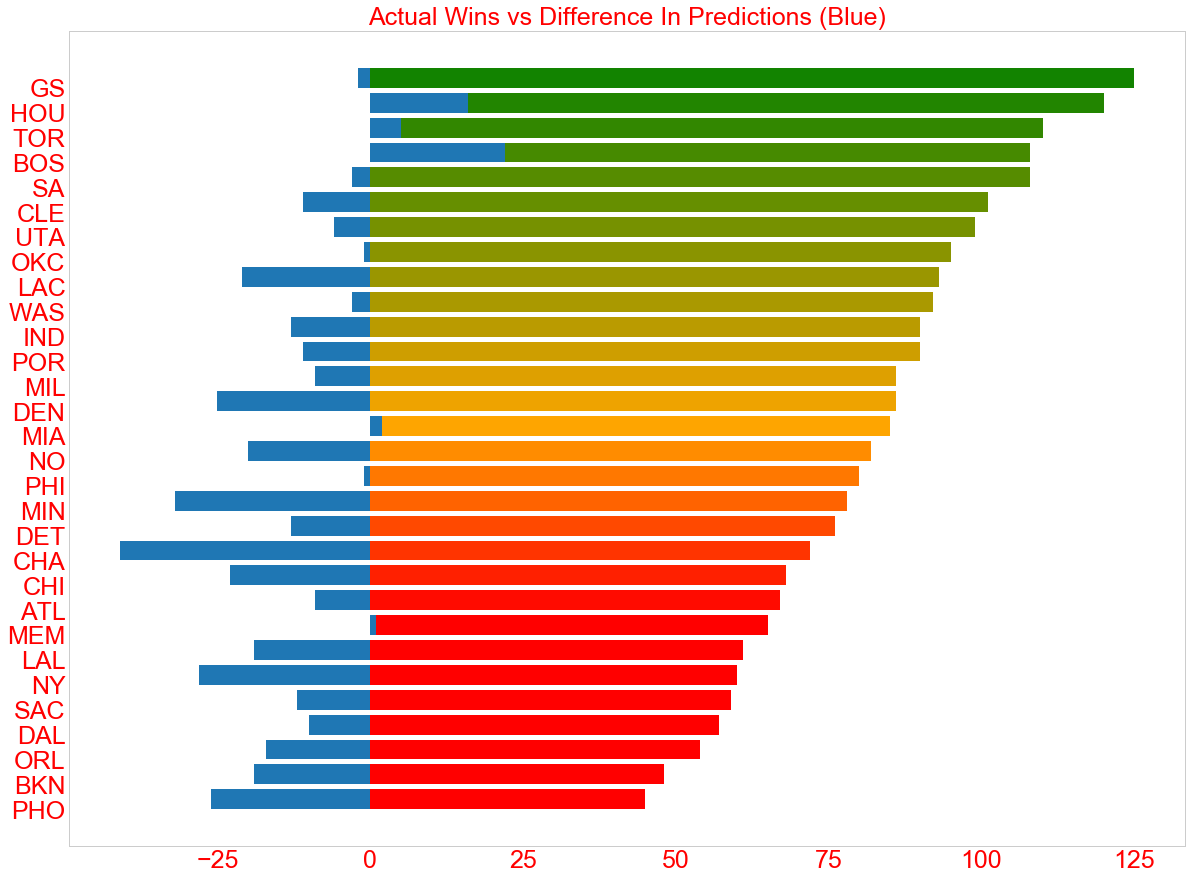

In [24]:
plt.figure(figsize=(20,15))
plt.style.use('seaborn-whitegrid')
plt.grid(b=None)
plt.yticks(fontsize=25,color='red')
plt.xticks(fontsize=25,color='red')


clist = [(0, "red"), (0.125, "red"), (0.25, "orange"), (0.5, "green"), 
         (0.7, "green"), (0.75, "blue"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
width = 0.5
N = 60
q = np.arange(N).astype(float)
plt.barh(results['teamAbbr'],results['teamRslt'],color=rvb(q/N),align='edge');
plt.barh(results['teamAbbr'],results['winDiff'],align='edge')
plt.title('Actual Wins vs Difference In Predictions (Blue)',fontsize=25,color='red');

In [25]:
#Create a second verison of the model
features = ['teamEFG%','teamTO%','teamTREB%', 'teamFT%','teamDayOff','teamLoc','teamPF']

In [26]:
X_train = train[features]
X_test = test[features]
y_train = train['teamRslt']
y_test = test['teamRslt']

In [27]:
lr = LogisticRegression()

In [28]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
preds_2 = lr.predict(X_test)

In [30]:
coefficients = pd.DataFrame(dict(zip(nba_data[features].columns,lr.coef_[0])),index=[0])
coefficients

,teamEFG%,teamTO%,teamTREB%,teamFT%,teamDayOff,teamLoc,teamPF
0,0.196692,-0.18434,0.155317,0.016133,0.004883,0.500365,-0.077276


In [31]:
accuracy_score(y_train,lr.predict(X_train))

0.7684488717218947

In [32]:
accuracy_score(y_test,lr.predict(X_test))

0.7526422764227643

In [33]:
test['predWin_2'] = preds_2

In [34]:
r = test.iloc[::2,:]['teamRslt']
p = test.iloc[::2,:]['predWin_2']

In [39]:
cm = confusion_matrix(test['teamRslt'],test['predWin_2'])
tn, fp, fn, tp = confusion_matrix(test['teamRslt'],test['predWin_2']).ravel()

In [40]:
print('True Negatives: ', tn)
print('False Positives: ', fp)
print('False Negatives: ', fn)
print('True Positives: ', tp)

True Negatives:  1577
False Positives:  883
False Negatives:  334
True Positives:  2126


In [41]:
#Classification metrics
accuracy = round((((tp+tn)/(tp+fn+tn+fp))*100),2)
misclassification = round(((1 - (accuracy/100))*100),2)
sensitivy = round(((tp/(tp+fn))*100),2)
specificity = round(((tn/(tn+fp))*100),2)
precision = round(((tp/(tp+fp))*100),2)
print('Accuracy Rate:',accuracy,'%')
print('Misclassification Rate:',misclassification,'%')
print('Sensitivy Rate:',sensitivy,'%')
print('Specificity Rate:',specificity,'%')
print('Precision Rate:',precision,'%')

Accuracy Rate: 75.26 %
Misclassification Rate: 24.74 %
Sensitivy Rate: 86.42 %
Specificity Rate: 64.11 %
Precision Rate: 70.65 %


In [42]:
cm_df = pd.DataFrame(cm, columns=['pred negative', 'pred positive'], index=['actual negative', 'actual positive'])
cm_df

,pred negative,pred positive
actual negative,1577,883
actual positive,334,2126


In [43]:
results2 = pd.DataFrame(test.groupby(['teamAbbr']).agg('sum')[['teamRslt','predWin_2']])
results2.sort_values(by=['teamRslt'], inplace=True)
results2 = results2.reset_index()

In [44]:
results2['winDiff'] = results2['teamRslt'] - results2['predWin_2']

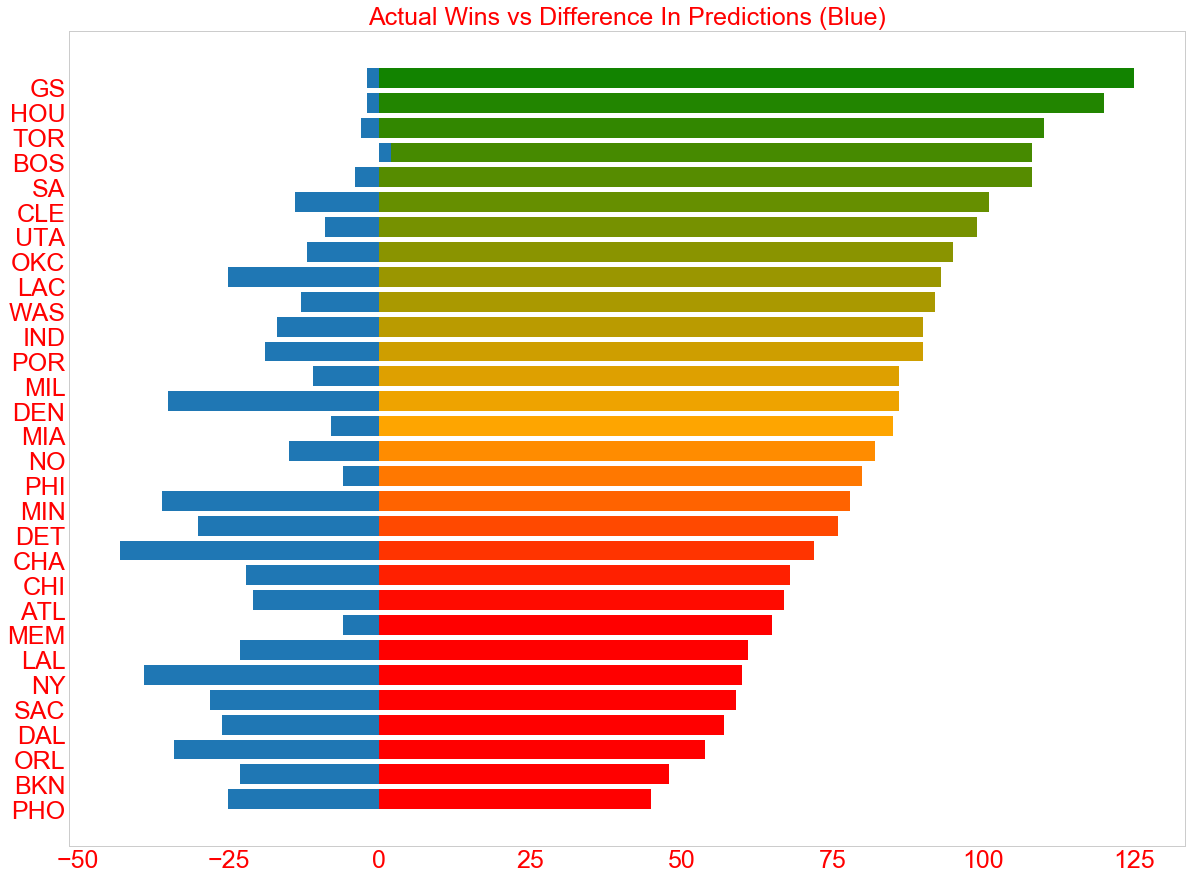

In [45]:
plt.figure(figsize=(20,15))
plt.style.use('seaborn-whitegrid')
plt.grid(b=None)
plt.yticks(fontsize=25,color='red')
plt.xticks(fontsize=25,color='red')


clist = [(0, "red"), (0.125, "red"), (0.25, "orange"), (0.5, "green"), 
         (0.7, "green"), (0.75, "blue"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
width = 0.5
N = 60
q = np.arange(N).astype(float)
plt.barh(results2['teamAbbr'],results2['teamRslt'],color=rvb(q/N),align='edge');
plt.barh(results2['teamAbbr'],results2['winDiff'],align='edge')
plt.title('Actual Wins vs Difference In Predictions (Blue)',fontsize=25,color='red');